In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

print('numpy==' + np.__version__)
print('pandas==' + pd.__version__)
print('matplotlib==' + matplotlib.__version__)
print('tensorflow-macos==' + tf.__version__)
print('sklearn==' + sklearn.__version__)

numpy==1.19.5
pandas==1.3.2
matplotlib==3.4.3
tensorflow-macos==2.6.0
sklearn==1.1.1


In [3]:
data_path = 'data/tweets_sentiment_score_price_10min_20210205_20220218.csv'
data = pd.read_csv(data_path).drop(['10min_TimeStart', 'time_period_end', 'time_open', 'time_close'], axis=1)

data.head()

,vander_pos,vander_neg,vander_neu,vander_compound,textblob_polarity,textblob_subjectivity,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,0.103182,0.015667,0.881152,0.222945,0.144697,0.353114,38320.00,38653.07,38230.81,38493.23,196.268287,884
1,0.100053,0.000000,0.899947,0.264474,0.121754,0.523839,38479.01,38570.55,38349.10,38378.40,19.371943,218
2,0.091455,0.058636,0.849909,0.114745,0.050000,0.404545,38391.75,38457.88,38312.39,38433.23,27.075617,255
3,0.062600,0.017650,0.919750,0.142785,0.087175,0.288680,38422.06,38814.14,38398.27,38725.77,82.466474,476
4,0.114654,0.019231,0.866115,0.243877,0.119671,0.424199,38697.97,38709.55,38574.50,38681.49,31.208460,184


In [4]:
data_features = data.drop(['price_close'], axis=1)
data_labels = data['price_close']

# data = data.to_numpy()

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))


train_size1 = int(0.7 * len(label))
train_size2 = int(0.9 * len(label))

In [5]:
print(data_features[:3])
print(data_labels[:3])

   vander_pos  vander_neg  vander_neu  vander_compound  textblob_polarity  \
0    0.103182    0.015667    0.881152         0.222945           0.144697   
1    0.100053    0.000000    0.899947         0.264474           0.121754   
2    0.091455    0.058636    0.849909         0.114745           0.050000   

   textblob_subjectivity  price_open  price_high  price_low  volume_traded  \
0               0.353114    38320.00    38653.07   38230.81     196.268287   
1               0.523839    38479.01    38570.55   38349.10      19.371943   
2               0.404545    38391.75    38457.88   38312.39      27.075617   

   trades_count  
0           884  
1           218  
2           255  
0    38493.23
1    38378.40
2    38433.23
Name: price_close, dtype: float64


In [6]:
def split_data(f, l):
    delay = 15 * 9
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

X_train, y_train = split_data(feature[:train_size1], label[:train_size1])
X_train2, y_train2 = split_data(feature[train_size1:train_size2], label[train_size1:train_size2])
X_test, y_test = split_data(feature[train_size2:], label[train_size2:])

In [7]:
models = [
    keras.Sequential([
        layers.GRU(128),
        layers.Dense(1)
    ]) for i in range(5)
]

2022-09-07 08:33:37.724358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 08:33:37.730103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 08:33:37.730281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 08:33:37.731076: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
for i, model in enumerate(models):
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00005),
                  metrics=[keras.metrics.RootMeanSquaredError()]
                  )
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=512,
                        validation_data=(X_test, y_test),
                        callbacks=[keras.callbacks.ModelCheckpoint('gru-10min-'+str(i)+'.h5', verbose=1, monitor='val_root_mean_squared_error',save_best_only=True, mode='auto')],
                        shuffle=True
                        )

/home/charles/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-09-07 08:33:38.635181: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-09-07 08:33:40.220867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8400


74/74 [==============================] - 3s 21ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 8.2083e-05 - val_root_mean_squared_error: 0.0091

Epoch 00001: val_root_mean_squared_error improved from inf to 0.00906, saving model to gru-10min-0.h5
Epoch 2/50
74/74 [==============================] - 1s 17ms/step - loss: 5.0094e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.6829e-05 - val_root_mean_squared_error: 0.0041

Epoch 00002: val_root_mean_squared_error improved from 0.00906 to 0.00410, saving model to gru-10min-0.h5
Epoch 3/50
74/74 [==============================] - 1s 17ms/step - loss: 3.5828e-05 - root_mean_squared_error: 0.0060 - val_loss: 1.4732e-05 - val_root_mean_squared_error: 0.0038

Epoch 00003: val_root_mean_squared_error improved from 0.00410 to 0.00384, saving model to gru-10min-0.h5
Epoch 4/50
74/74 [==============================] - 1s 17ms/step - loss: 2.8573e-05 - root_mean_squared_error: 0.0053 - val_loss: 1.3285e-05 - val_root_mean_squa

In [9]:
models = []
for i in range(5):
    # models.append(tf.keras.models.load_model('../Trained_Models/gru'+str(i)+'.h5'))
    models.append(tf.keras.models.load_model('gru-10min-'+str(i)+'.h5'))

In [10]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test))

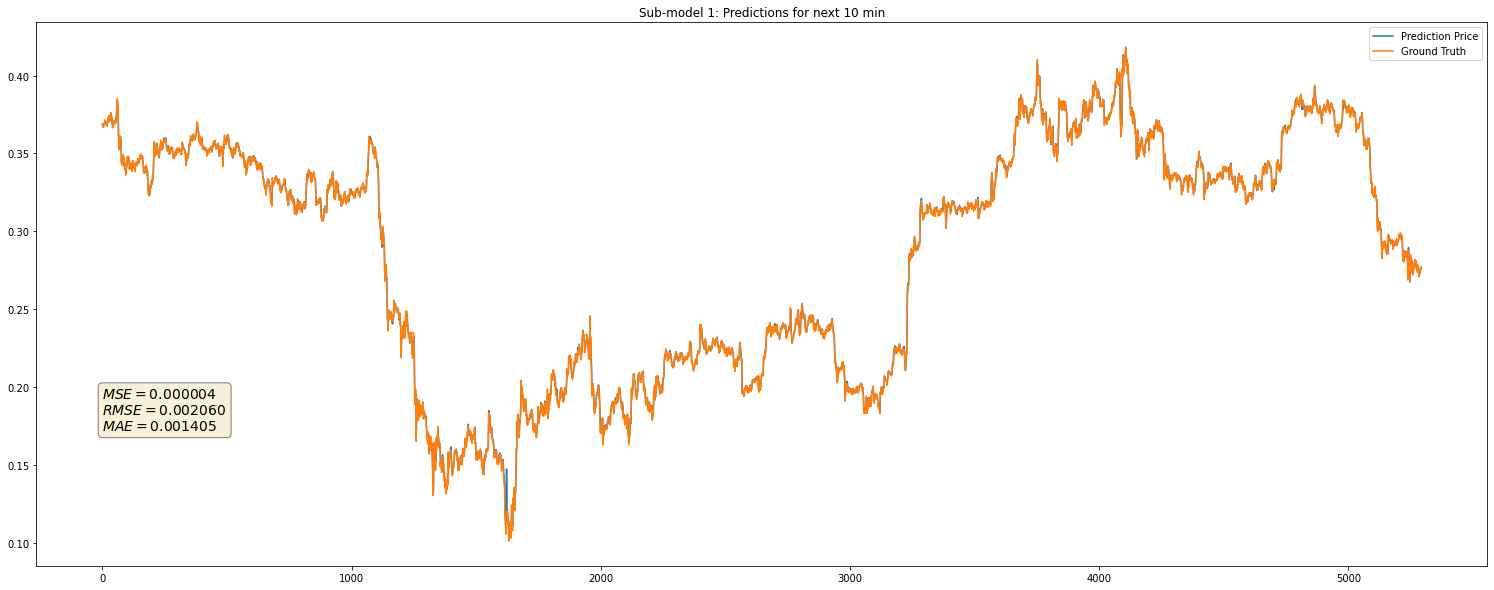

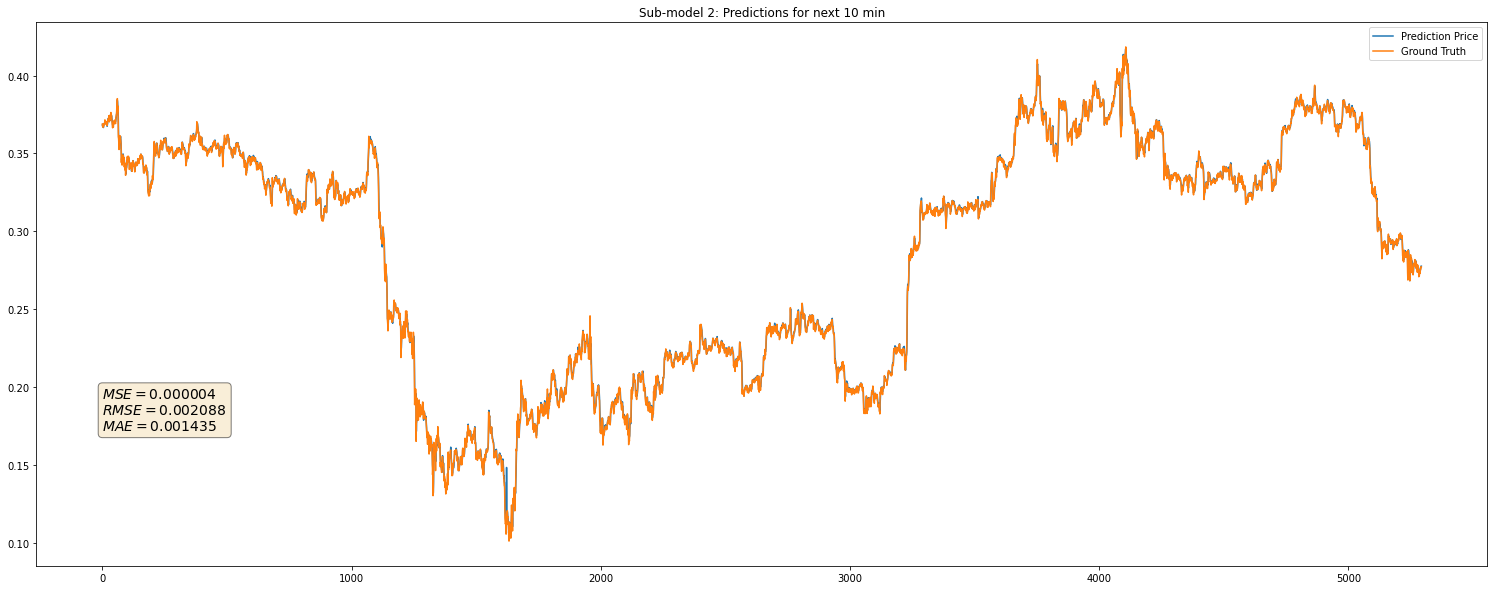

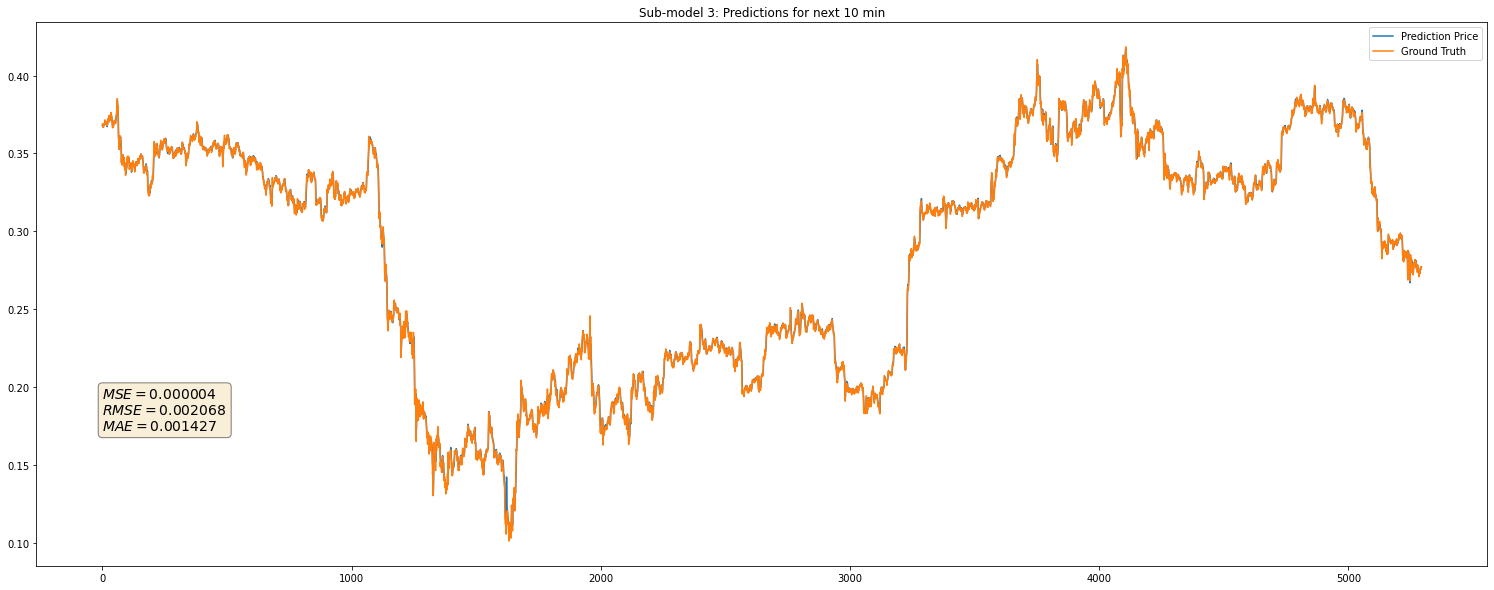

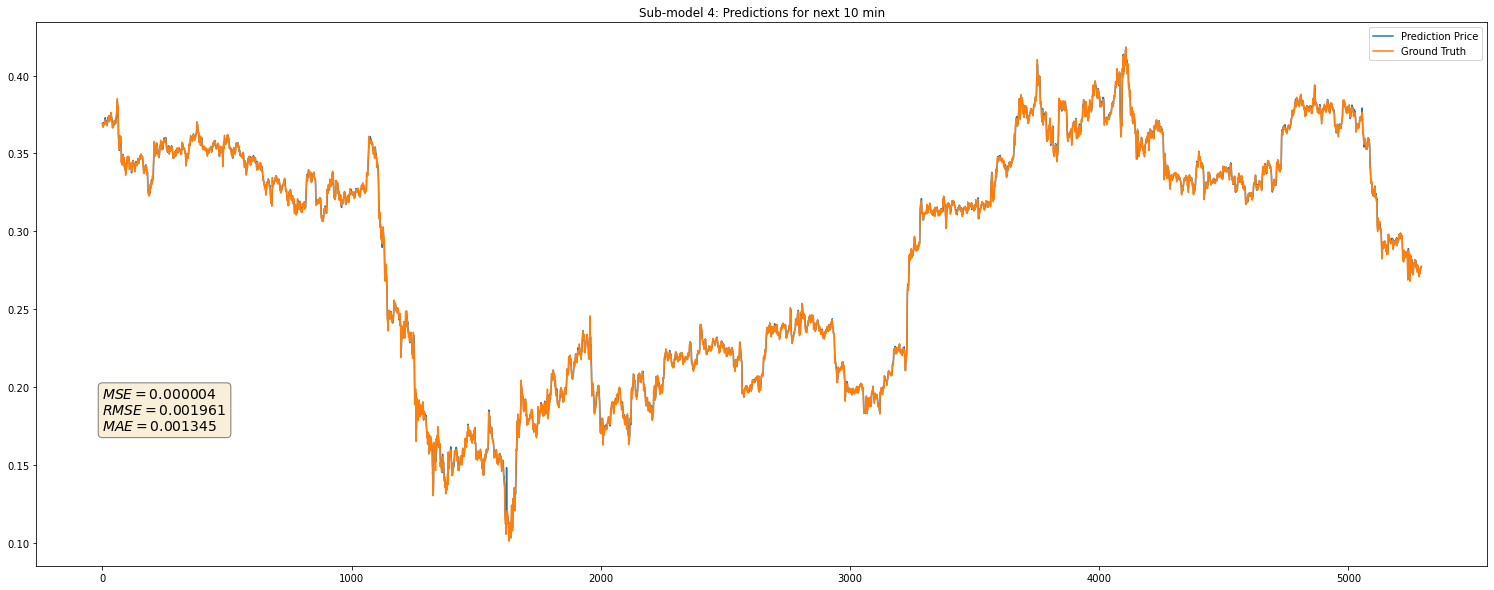

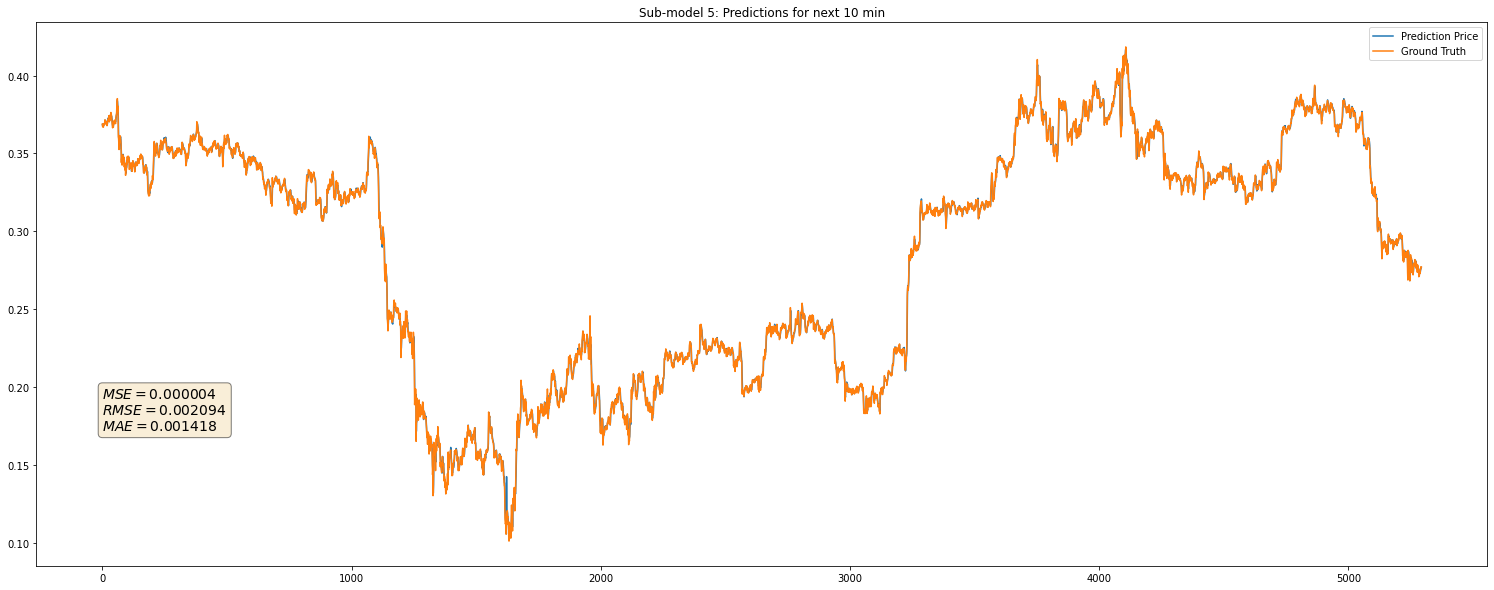

In [11]:
# prediction = model.predict(X_test)
for i, prediction in enumerate(predictions):
    mse = mean_squared_error(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mae = mean_absolute_error(y_test, prediction)

    metrics = '\n'.join((
        '$MSE=%f$' % (mse),
        '$RMSE=%f$' % (rmse),
        '$MAE=%f$' % (mae)
    ))

    plt.figure(figsize=(26, 10))
    plt.plot(prediction, label='Prediction Price')
    plt.plot(y_test, label='Ground Truth')
    plt.legend()
    plt.title('Sub-model ' + str(i+1) + ': Predictions for next 10 min')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.1, 0.2, metrics, fontsize=14,
            verticalalignment='top', bbox=props)

    # plt.savefig('no_senti.png', dpi=500)
    plt.show()

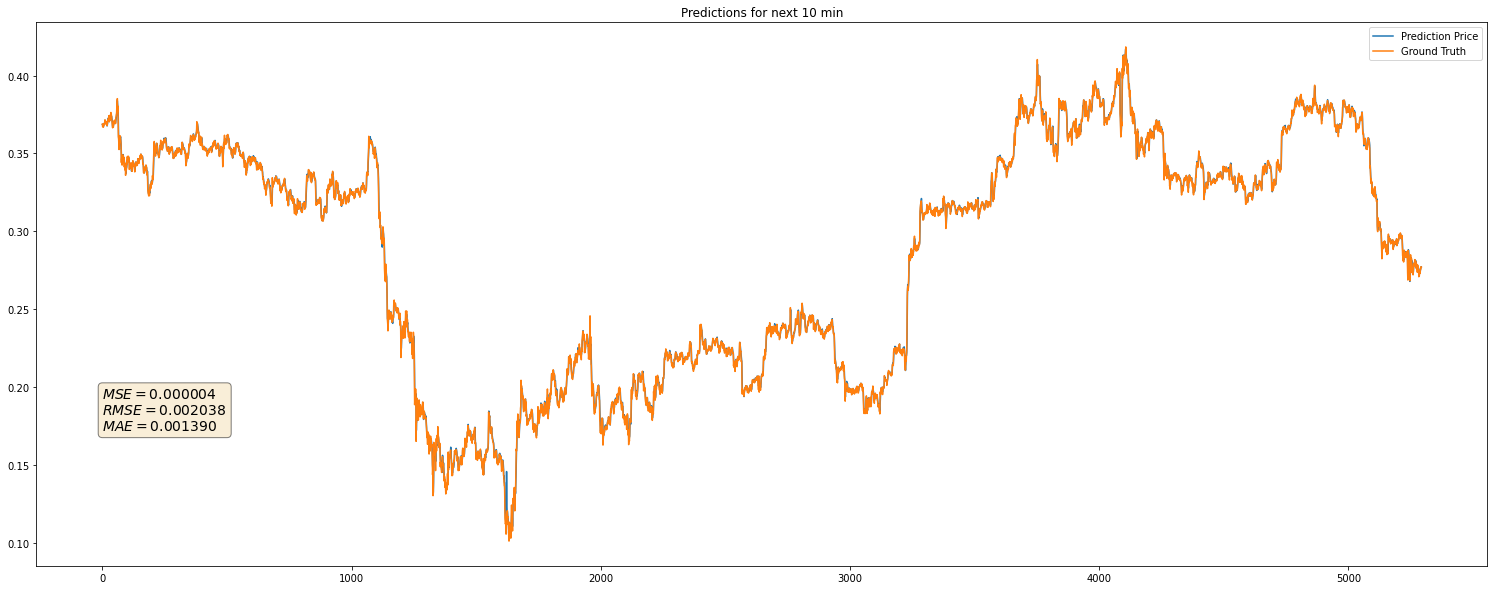

In [12]:
prediction = np.mean(np.array(predictions), axis=0)
mse = mean_squared_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)
mae = mean_absolute_error(y_test, prediction)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(prediction, label='Prediction Price')
plt.plot(y_test, label='Ground Truth')
plt.legend()
plt.title('Predictions for next 10 min')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.1, 0.2, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()

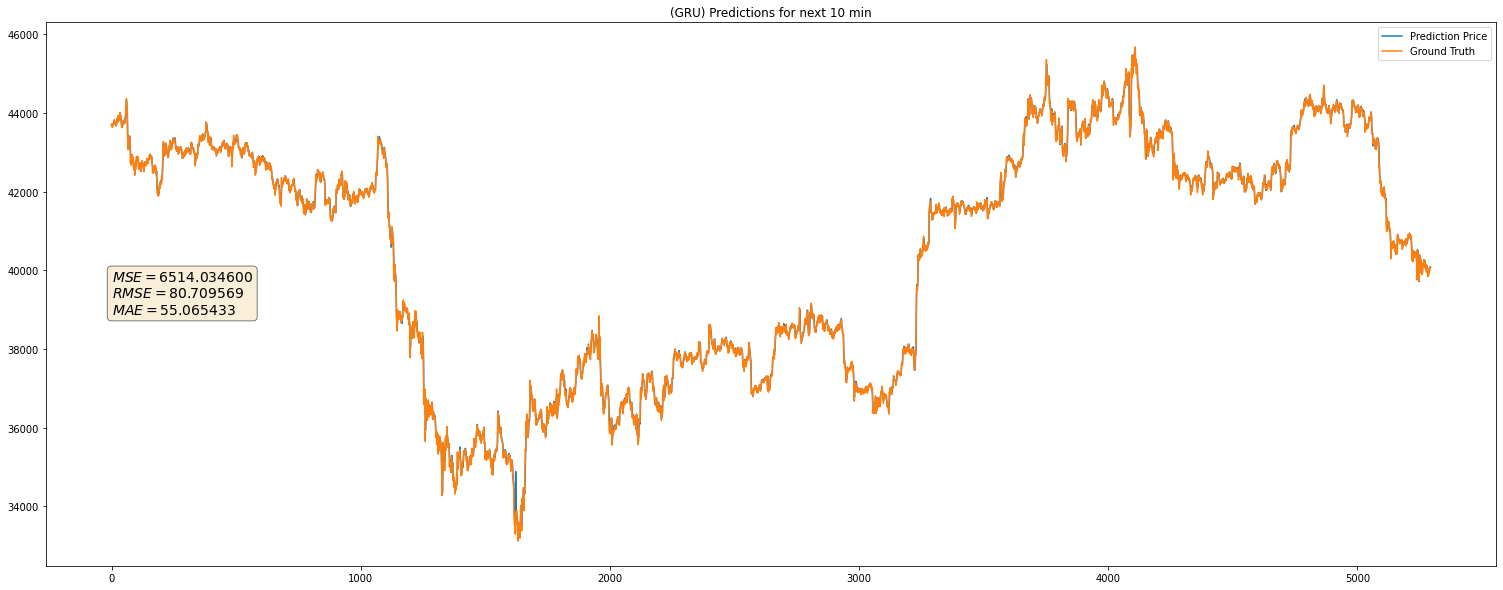

In [13]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('(GRU) Predictions for next 10 min')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 40000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()